In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

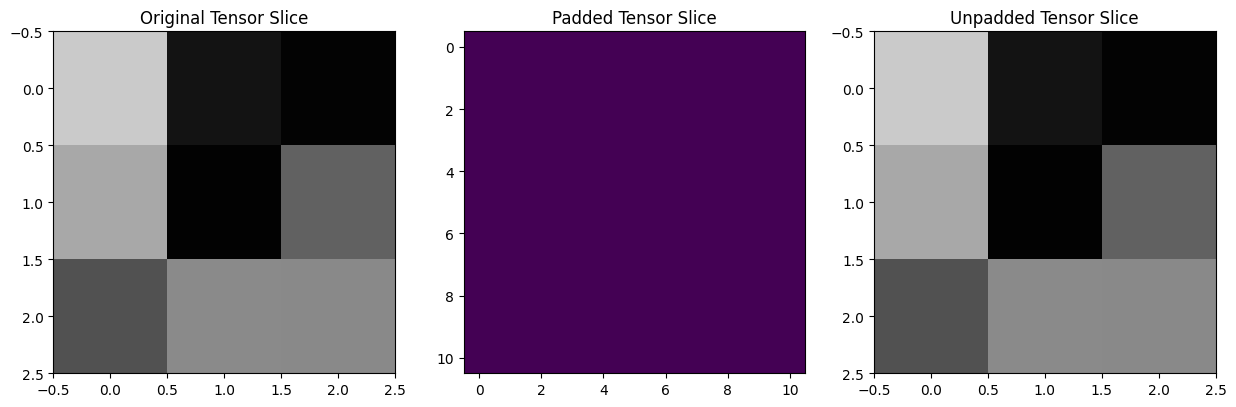

In [13]:
# Initialize x
x = torch.rand(1, 1, 3, 3, 3)

# Initialize the padding
padding = 4
p3d = (padding, padding, padding, padding, padding, padding)

# Pad the tensor
x_padded = F.pad(x, p3d)

# Now let's remove the padding
x_unpadded = x_padded[..., padding:-padding, padding:-padding, padding:-padding]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Original tensor
axs[0].imshow(x[0, 0, :, :, 0], cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Tensor Slice')

# Padded tensor
axs[1].imshow(x_padded[0, 0, :, :, 0], cmap='gray')
axs[1].set_title('Padded Tensor Slice')

# Unpadded tensor
axs[2].imshow(x_unpadded[0, 0, :, :, 0], cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Unpadded Tensor Slice')

plt.show()
#




        



###DEBUG NORMALIZATION

In [23]:
import torch.nn.functional as F
from utilities import *
from timeit import default_timer
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [56]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class PointGaussianNormalizer(object):
    def __init__(self, dataloader, is_label=False, eps=0.00001):
        super(PointGaussianNormalizer, self).__init__()
        self.eps = eps
        self.mean, self.std = self.batch_mean_and_sd(dataloader, is_label)

    def batch_mean_and_sd(self, loader, is_label):
        cnt = 0
        fst_moment = torch.empty(loader.dataset.tensors[0].shape[-1])
        snd_moment = torch.empty(loader.dataset.tensors[0].shape[-1])

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            b, t, h, w, c = data.shape
            nb_pixels = b * t * h * w
            sum_ = torch.sum(data, dim=[0, 1, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 1, 2, 3])
            fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
            snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
            cnt += nb_pixels

        return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [64]:
# Generate some sample data
data = torch.randn(100, 61, 32, 32, 6)*2000
labels = torch.randn(100, 61, 32, 32, 1)*3000

# Create dataloader
dataset = TensorDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=10)

# Create normalizers
input_normalizer = PointGaussianNormalizer(dataloader, is_label=False)
label_normalizer = PointGaussianNormalizer(dataloader, is_label=True)

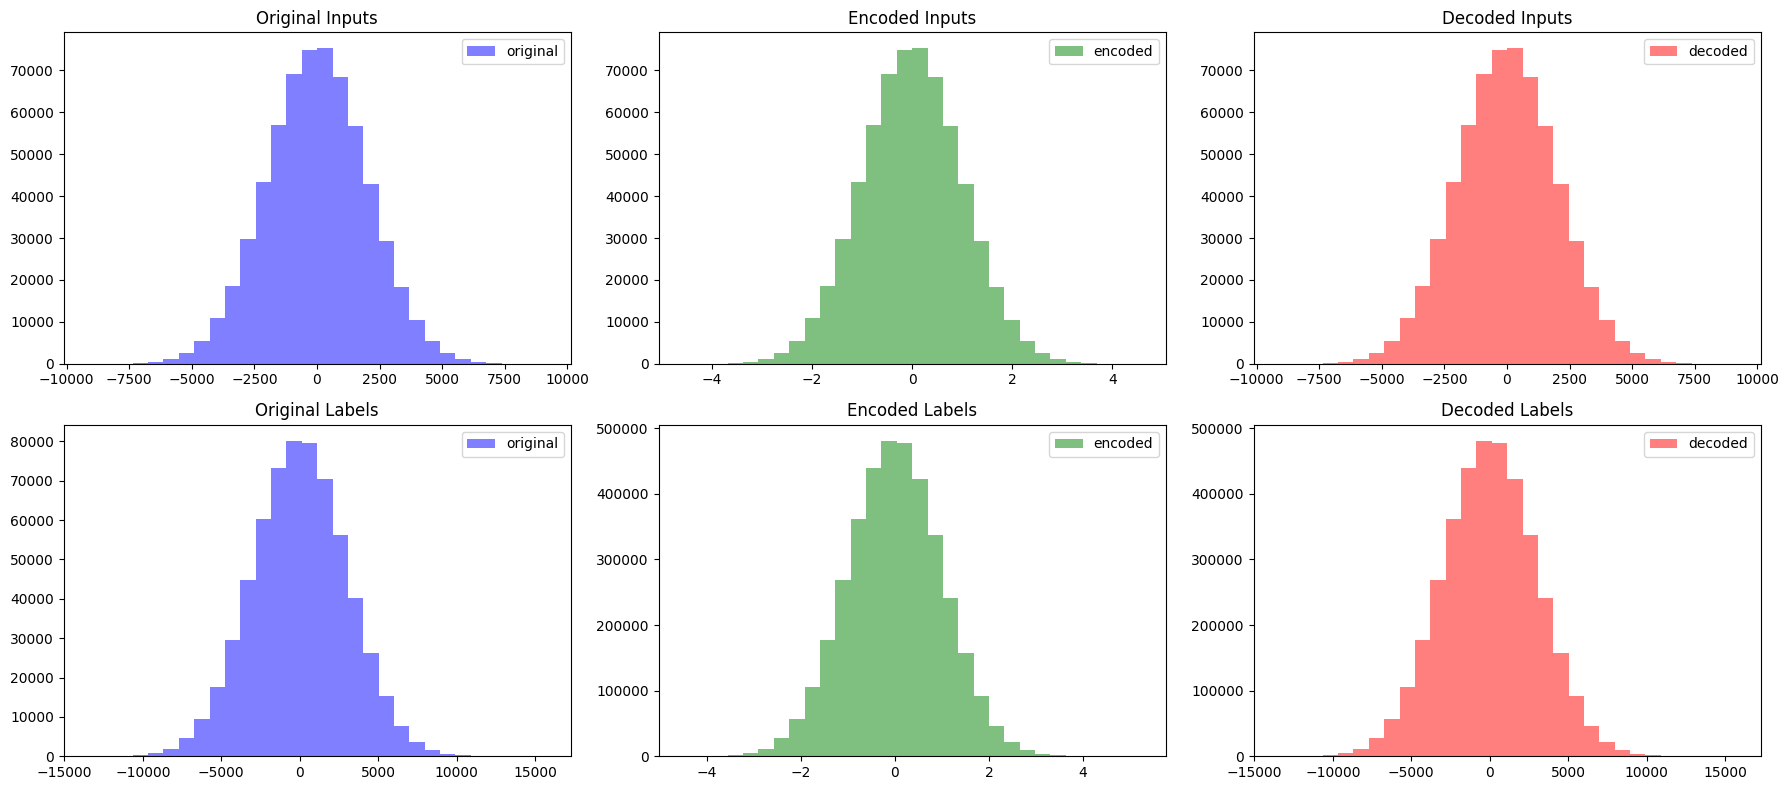

In [68]:
import matplotlib.pyplot as plt

# Pick the first batch of data
inputs, labels = next(iter(dataloader))

# Normalize inputs and labels
normalized_inputs = input_normalizer.encode(inputs)
normalized_labels = label_normalizer.encode(labels)

# Decode the normalized inputs and labels
decoded_inputs = input_normalizer.decode(normalized_inputs)
decoded_labels = label_normalizer.decode(normalized_labels)

# Pick a feature index to plot (any integer from 0 to 5 for your case)
feature_idx = 0

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

# Plot original inputs
axes[0, 0].hist(inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[0, 0].set_title('Original Inputs')

# Plot encoded inputs
axes[0, 1].hist(normalized_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[0, 1].set_title('Encoded Inputs')

# Plot decoded inputs
axes[0, 2].hist(decoded_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[0, 2].set_title('Decoded Inputs')

# Plot original labels
axes[1, 0].hist(labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[1, 0].set_title('Original Labels')

# Plot encoded labels
axes[1, 1].hist(normalized_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[1, 1].set_title('Encoded Labels')

# Plot decoded labels
axes[1, 2].hist(decoded_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[1, 2].set_title('Decoded Labels')

for ax_row in axes:
    for ax in ax_row:
        ax.legend()

plt.tight_layout()
plt.show()


In [47]:
import matplotlib.pyplot as plt

# Create some indices to sample data (select a subset to avoid plotting too much data)
indices = torch.randint(0, len(data), (1000,))

# Sample original, encoded, and decoded data
original_sample = data.view(-1, 6)[indices]
encoded_sample = encoded_data.view(-1, 6)[indices]
decoded_sample = decoded_data.view(-1, 6)[indices]

# For each feature dimension
for i in range(6):
    plt.figure(figsize=(15, 5))
    
    # Plot original data distribution
    plt.subplot(131)
    plt.hist(original_sample[:, i].numpy(), bins=30)
    plt.title('Original Data - Feature {}'.format(i))

    # Plot encoded data distribution
    plt.subplot(132)
    plt.hist(encoded_sample[:, i].numpy(), bins=30)
    plt.title('Encoded Data - Feature {}'.format(i))

    # Plot decoded data distribution
    plt.subplot(133)
    plt.hist(decoded_sample[:, i].numpy(), bins=30)
    plt.title('Decoded Data - Feature {}'.format(i))

    plt.show()


AttributeError: 'list' object has no attribute 'view'

In [34]:
decoded_data.shape

torch.Size([100, 61, 32, 32, 6])

In [11]:
torch.mean(data, dim=(0)).shape

torch.Size([61, 32, 32, 6])

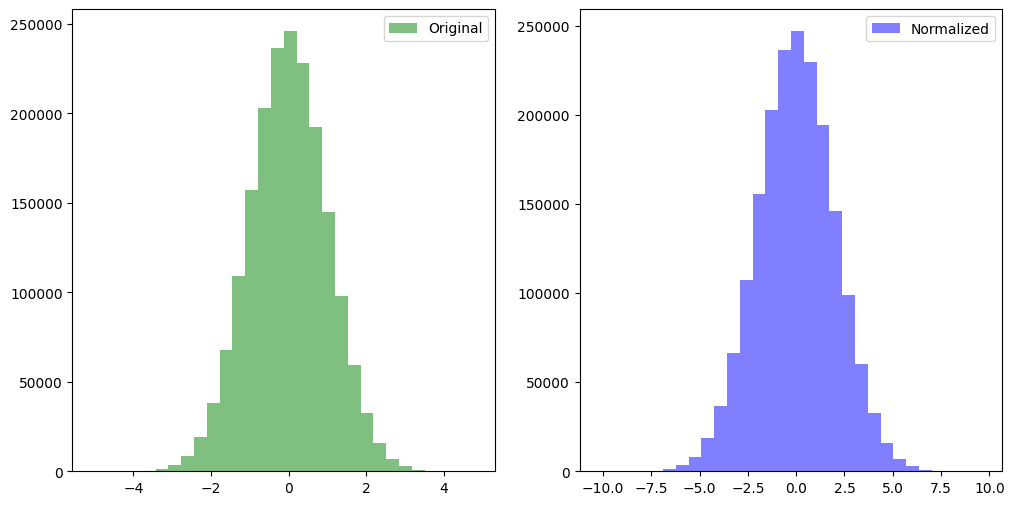

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the tensors for histogram
original_data = data.flatten().numpy()
normalized_data = encoded.flatten().numpy()

# Plot original data
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.hist(original_data, bins=30, alpha=0.5, color='g', label='Original')
plt.legend()

# Plot normalized data
plt.subplot(1, 2, 2)
plt.hist(normalized_data, bins=30, alpha=0.5, color='b', label='Normalized')
plt.legend()

plt.show()


In [2]:
################################################################
# configs-1
################################################################
folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results256/"
input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
output_vars = ['CO_2'] 



num_files= 100
traintest_split = 0.8

batch_size = 61

ntrain = num_files*traintest_split
ntest = num_files - ntrain

S = 32
#T_in = 61
T = 61

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [25]:
# Create instance of ReadXarrayDatasetNorm class for training data
dataset = ReadXarrayDatasetNoNorm(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files = num_files)

train_size = int(traintest_split * len(dataset))
test_size = len(dataset) - train_size

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))

In [36]:
# import sys for getting size of objects
import sys

# Use an example item from the dataset
example_item = dataset[0]

# Print memory usage of each part of the example_item
print("Size of input data: ", sys.getsizeof(example_item[0]))
print("Size of output data: ", sys.getsizeof(example_item[1]))


Size of input data:  72
Size of output data:  72


In [38]:
import random
# Check random subset of dataset
for _ in range(100):  # Adjust this number as needed
    idx = random.randint(0, len(dataset) - 1)  # Get a random index
    input_data, output_data = dataset[idx]


In [39]:
# Assuming you've made necessary changes to your Dataset class to include normalizer
normalizer = PointGaussianNormalizer()

# Get an example item from your dataset
example_item = dataset[0]  # Or get a specific item if you want
input_data, output_data = example_item

# Normalize the data
normalized_input_data = normalizer.encode(input_data)
normalized_output_data = normalizer.encode(output_data)

# Then denormalize it back
denormalized_input_data = normalizer.decode(normalized_input_data)
denormalized_output_data = normalizer.decode(normalized_output_data)

# Compare the original data and the denormalized data
# They should be almost equal within a small margin of error due to floating point precision
assert torch.allclose(input_data, denormalized_input_data, atol=1e-7), "Input data not almost equal after normalization and denormalization"
assert torch.allclose(output_data, denormalized_output_data, atol=1e-7), "Output data not almost equal after normalization and denormalization"

print("Normalization and denormalization tests passed!")


TypeError: __init__() missing 1 required positional argument: 'x'

In [28]:
import torch

# Create random data
batch_size = 100
x = torch.randn(batch_size, 61, 32, 32, 6)

# Create normalizer
normalizer = PointGaussianNormalizer(x)

# Encode the data
encoded_x = normalizer.encode(x.clone())  # Using clone to not alter original x during encoding

# Decode the data
decoded_x = normalizer.decode(encoded_x)

# Check if the decoded data is close to the original data
# We use a small tolerance due to floating point precision
tolerance = 1e-6





In [29]:
assert torch.allclose(x, decoded_x, atol=tolerance), "Decoded data is not close to original data"

In [30]:
class LargePointGaussianNormalizer(object):
    def __init__(self, shape, eps=0.00001):
        super(LargePointGaussianNormalizer, self).__init__()

        # Initialize running mean and running variance
        self.running_mean = torch.zeros(shape[1:], dtype=torch.float32)
        self.running_var = torch.zeros(shape[1:], dtype=torch.float32)
        self.count = 0
        self.eps = eps

    def update_parameters(self, x):
        # Use Welford's method to compute running mean and variance
        self.count += x.shape[0]
        delta = x - self.running_mean
        self.running_mean += torch.mean(delta, 0)
        self.running_var += torch.mean(delta * (x - self.running_mean), 0)
        
    def finalize_parameters(self):
        # Finalize mean and std computation
        self.mean = self.running_mean
        self.std = torch.sqrt(self.running_var / (self.count - 1))
        del self.running_mean, self.running_var

    def encode(self, x):
        assert hasattr(self, 'mean'), "Must finalize parameters before encoding"
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x):
        assert hasattr(self, 'mean'), "Must finalize parameters before decoding"
        x = (x * self.std) + self.mean
        return x


In [35]:
normalizer = LargePointGaussianNormalizer((batch_size, 61, 32, 32, 6))
num_batches=1000
# Simulate streaming data
for i in range(num_batches):
    batch = load_batch(i)  # Replace with your method of loading a batch of data
    normalizer.update_parameters(batch)

normalizer.finalize_parameters()

# Now normalizer can be used to encode and decode data


NameError: name 'load_batch' is not defined

In [23]:
import tracemalloc

tracemalloc.start()

# Your code here

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
tracemalloc.stop()

Current memory usage is 0.000469MB; Peak was 0.010674MB


In [15]:
# Get input and output data tensors
train_a = dataset.train_data_input
train_u = dataset.train_data_output

test_a = dataset.test_data_input
test_u = dataset.test_data_output

# Move data tensors to GPU if available
train_a = train_a.to(device)
train_u = train_u.to(device)

test_a = test_a.to(device)
test_u = test_u.to(device)

# Normalize input_data and output_data
a_normalizer = PointGaussianNormalizer(train_a)
train_a= a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = PointGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)
test_u = y_normalizer.encode(test_u)


AttributeError: 'ReadXarrayDatasetNoNorm' object has no attribute 'train_data_input'